# Classification

We want to build a deep neural network model by implementing Convolutional Neural Network (CNN) to classify dog and cat images

## Import library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
input_path = '/Users/ybao2/Github_Repo/deep-learning-with-python-notebooks/data/Dog_Cat_Classification'
print(os.listdir(input_path))

['test1.zip', 'train', 'train.zip']


## 1. Initial steps

## 1.1 Prepare data

In [ ]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
filenames = os.listdir(input_path + "/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


## 1.2 Data Exploration

<Axes: xlabel='category'>

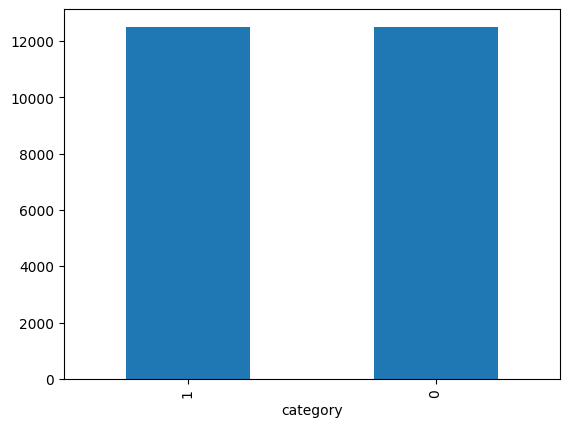

In [6]:
df['category'].value_counts().plot.bar()

We have 12000 dogs (1) and 12000 cats (0)

See a random image

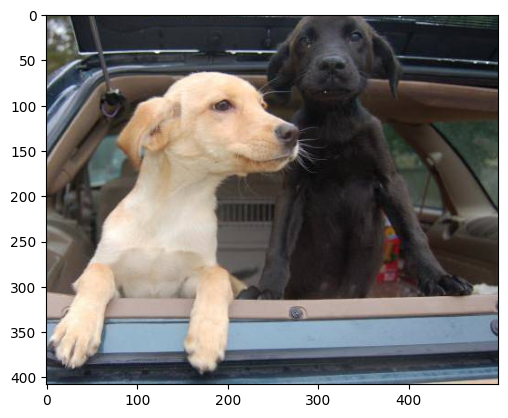

In [7]:
sample = random.choice(filenames)
image = load_img(input_path + "/train/" +sample)
plt.imshow(image)

See ten dogs

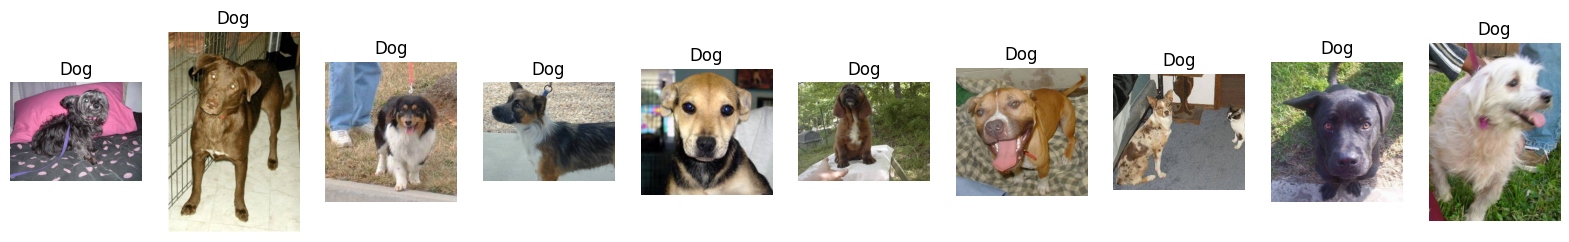

In [8]:
from matplotlib.image import imread
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):
    
    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = input_path + '/train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()


## 2. Build model

### 2.1 Initial build

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

### 2.2 Callbacks

we will be using two callbacks
- ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.
- EarlyStopping : Stop training when a monitored metric has stopped improving

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stop

# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

# Learning Rate Reduction

# We will reduce the learning rate when then accuracy not increase for 2 steps

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

### 2.3 Prepare data again

To use image genaretor with class_mode="categorical". We need to convert column category into string. 1-dog; 0-cat

In [11]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

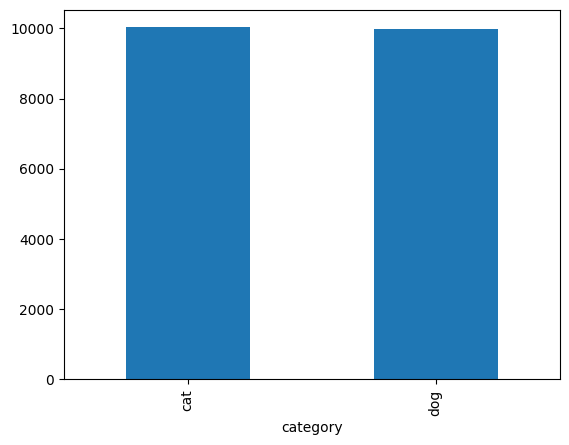

In [12]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

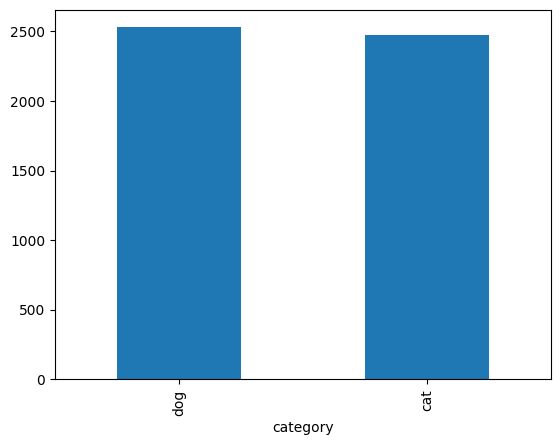

In [13]:
validate_df['category'].value_counts().plot.bar()

We see that we have 10000 training objects and 2500 validation objects for each category.

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Applying image data gernerator to train and test data

### 2.4 Traning Generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    input_path + "/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### 2.5 Validation Generator

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    input_path + "/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## 3. See how model performs

## 4. Fit Model

In [21]:
import scipy
epoch_size = 3
cat_dog = model.fit(train_generator,
                    validation_data = validation_generator, 
                    callbacks = [earlystop, learning_rate_reduction],
                    epochs = epoch_size,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/3
1334/1334 [==============================] - 217s 163ms/step - loss: 0.4675 - accuracy: 0.7840 - val_loss: 0.9967 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 2/3
1334/1334 [==============================] - 214s 160ms/step - loss: 0.4349 - accuracy: 0.8042 - val_loss: 0.3616 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/3
1334/1334 [==============================] - 219s 164ms/step - loss: 0.4145 - accuracy: 0.8162 - val_loss: 0.3568 - val_accuracy: 0.8484 - lr: 0.0010


## 5. Check model performance

### 5.1 Visualize

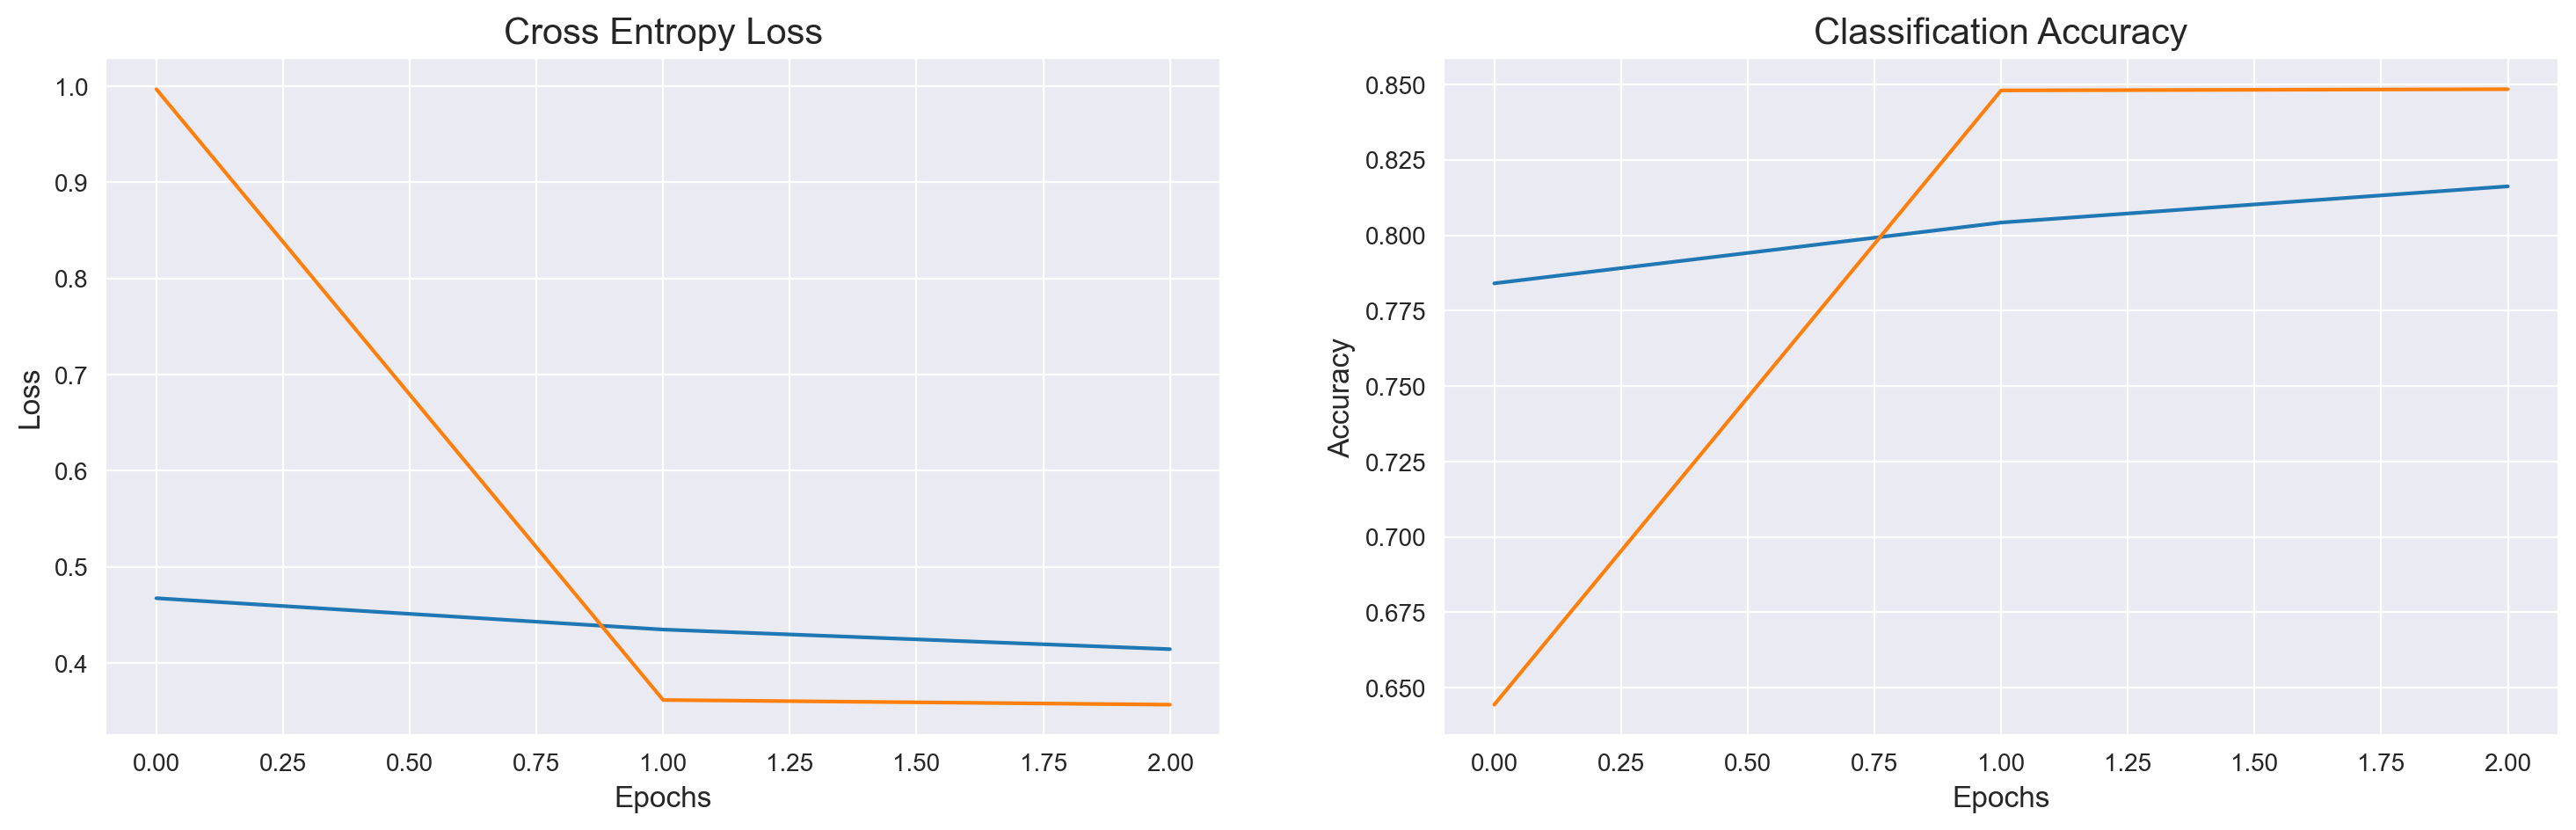

In [22]:
import seaborn as sns
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

### 5.2 Summarize accuracy

In [23]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(validation_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 81.01999759674072
The Loss of the model for training data is: 0.41468462347984314
The accuracy of the model for validation data is: 84.83999967575073
The Loss of the model for validation data is: 0.35677000880241394


In [24]:
# Save the Model
model.save("model.h5")

/Users/ybao2/opt/anaconda3/envs/py38_kaggle/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6. Predict

In [26]:
# prediction
result = model.predict(validation_generator,batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = validation_generator.labels

# Evaluvate
loss,acc = model.evaluate(validation_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 84.83999967575073
The Loss of the model for testing data is: 0.35677000880241394


Classification report

In [27]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.49      0.50      0.50      2472
         Dog       0.51      0.50      0.50      2528

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



Confusion matrix

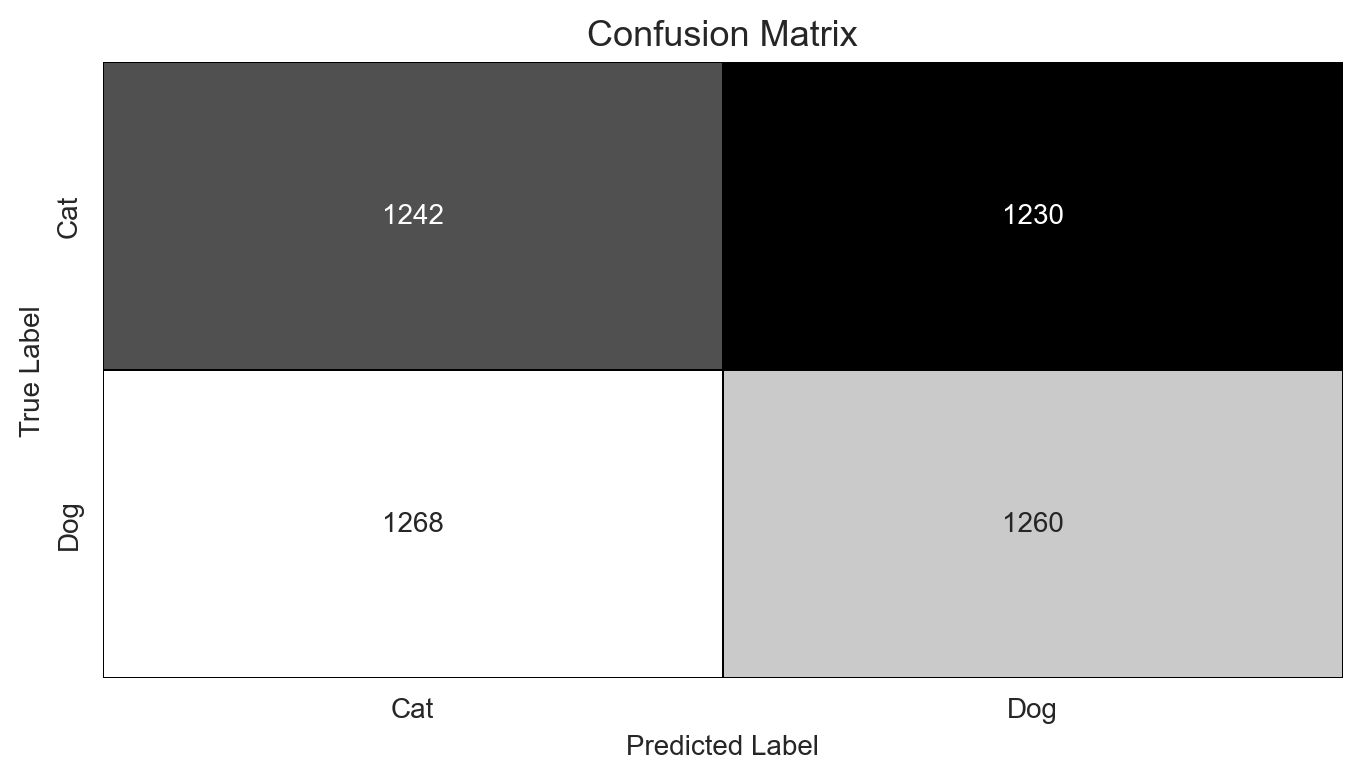

In [28]:
confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

What we see here is that the model training is not long enough. Adding more epochs and running it longer will help.

# Reference
1. https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification
2. https://www.kaggle.com/code/sachinpatil1280/cats-vs-dogs-image-classification-using-cnn-95